In [1]:
import os
import sys
import numpy as np
from sklearn.linear_model import LinearRegression

root_path = os.path.abspath("..")  
if root_path not in sys.path:
    sys.path.insert(0, root_path)
os.chdir("..")

In [2]:
from data.loader import load_complete_dataset
from data.preprocessing import add_module_columns

dataset = load_complete_dataset()
add_module_columns(dataset)

,device_id,accelerometer_x,accelerometer_y,accelerometer_z,gyroscope_x,gyroscope_y,gyroscope_z,magnetometer_x,magnetometer_y,magnetometer_z,timestamp,actitivy_label,participant_id,magnetometer_module,gyroscope_module,accelerometer_module
0,1.0,-2.82430,9.1773,2.2388,-1.43340,-0.003309,-0.41384,-0.85484,0.50402,0.674830,1735.1,1.0,14,1.200076,1.491948,9.859601
1,1.0,-2.80020,9.1655,2.2507,-1.04340,0.230960,-0.12186,-0.85887,0.52610,0.674830,1754.6,1.0,14,1.212367,1.075582,9.844448
2,1.0,-2.78810,9.1296,2.2634,-1.12080,0.215210,-0.10277,-0.85081,0.52811,0.683740,1774.2,1.0,14,1.212550,1.145893,9.810509
3,1.0,-2.82400,9.1173,2.2522,-1.15170,0.143390,0.32778,-0.84879,0.50402,0.688200,1793.7,1.0,14,1.203370,1.205991,9.806760
4,1.0,-2.82400,9.1414,2.2517,-1.36180,-0.113230,0.65311,-0.86290,0.51807,0.683740,1813.2,1.0,14,1.216755,1.514554,9.829055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53114,5.0,-0.48220,9.4431,-2.1914,0.70696,-0.734460,1.05760,-0.13535,0.71257,0.069565,1038000.0,1.0,0,0.728639,1.468925,9.706023
53115,5.0,-0.47013,9.4553,-2.1919,0.23155,-0.340820,0.98911,-0.12525,0.67265,0.071739,1038000.0,1.0,0,0.687962,1.071500,9.717415
53116,5.0,-0.49463,9.4428,-2.2155,0.53524,-0.291600,1.00350,-0.11919,0.69461,0.071739,1038000.0,1.0,0,0.708404,1.174106,9.711826
53117,5.0,-0.47013,9.4553,-2.1919,0.23140,-0.326390,0.89815,-0.11313,0.72056,0.084783,1038100.0,1.0,0,0.734298,0.983234,9.717415


### treinar o modelo para a melhor janela

Treino: 113477 linhas | Teste: 48633 linhas

--- Iniciando GCV Multivariado (Target: accelerometer_module) ---

 Melhor: Janela p=211
   GCV Score: 0.972648

RESULTADOS NO TESTE:
R2 Score: 0.8295 (Quanto mais perto de 1.0, melhor)
MSE: 1.160849


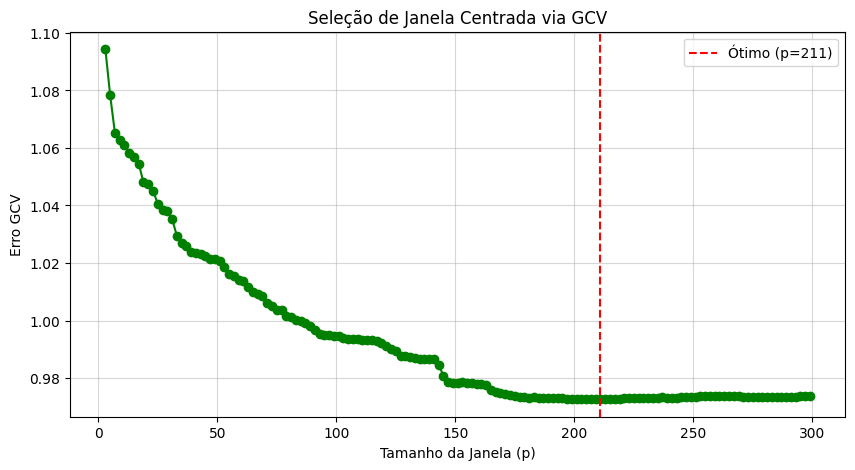

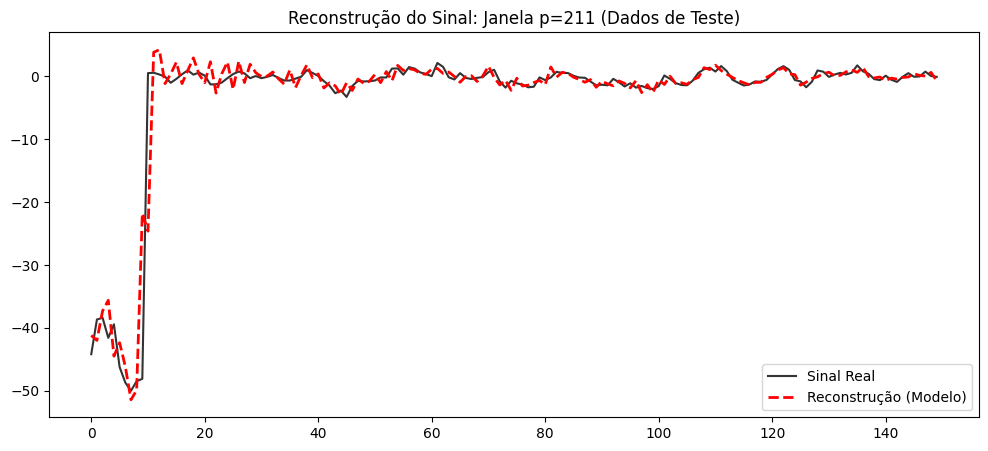

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from numpy.lib.stride_tricks import sliding_window_view

# ==========================================
# 1. FUNÇÕES AUXILIARES (ATUALIZADAS)
# ==========================================

def create_centered_window(data, target_col, p, feature_cols=None):
    """
    Versão otimizada para Janelas Centradas Multivariadas.
    """
    if p % 2 == 0:
        raise ValueError("O tamanho da janela 'p' deve ser ímpar.")
    
    half = p // 2
    if feature_cols is None:
        feature_cols = [c for c in data.columns if c != target_col]
    
    # Converter para numpy
    target_data = data[target_col].to_numpy()
    features_data = data[feature_cols].to_numpy()
    
    # 1. Janelas do ALVO (Target)
    window_target = sliding_window_view(target_data, window_shape=p)
    # Remover o centro (o que queremos prever)
    mask = np.ones(p, dtype=bool)
    mask[half] = False
    X_target = window_target[:, mask]

    # 2. Janelas das FEATURES (Outros sensores)
    # Se houver outras features, usamos a janela completa (incluindo centro)
    if features_data.shape[1] > 0:
        window_features = sliding_window_view(features_data, window_shape=p, axis=0)
        X_features = window_features.reshape(window_features.shape[0], -1)
        X = np.hstack([X_target, X_features])
    else:
        X = X_target # Univariado
    
    # 3. Target Y (O valor central que removemos)
    y = window_target[:, half]

    return X, y

def gcv_linear_regression(X, y):
    """
    GCV Clássico para Regressão Linear.
    """
    n, p_dim = X.shape
    
    model = LinearRegression(fit_intercept=True)
    model.fit(X, y)
    
    y_pred = model.predict(X)
    residuals = y - y_pred
    rss = np.sum(residuals**2)
    
    # Degrees of Freedom (colunas + intercept)
    hat_trace = p_dim + 1 
    
    mse = rss / n
    denominator = (1 - hat_trace / n) ** 2
    
    if denominator <= 0: return np.inf, model
    return mse / denominator, model

# ==========================================
# 2. CARREGAMENTO E PREPARAÇÃO
# ==========================================
TARGET_COL = "accelerometer_module"
FEATURE_COLS = ["gyroscope_module", "magnetometer_module"] # Colunas extra

# Filtrar dados (Do seu código original)
raw_df = dataset.loc[
    (dataset["device_id"] == DEVICES[0]) & (dataset["actitivy_label"] == 1),
    [TARGET_COL] + FEATURE_COLS
].copy()

# Escalonamento 
scaler = RobustScaler()
# Escalamos o DataFrame inteiro de uma vez para manter a estrutura
df_scaled = pd.DataFrame(scaler.fit_transform(raw_df), columns=raw_df.columns, index=raw_df.index)

# Divisão Treino/Teste (70/30)
split_point = int(len(df_scaled) * 0.7)
train_df = df_scaled.iloc[:split_point]
test_df = df_scaled.iloc[split_point:]

print(f"Treino: {len(train_df)} linhas | Teste: {len(test_df)} linhas")

# ==========================================
# 3. LOOP DE SELEÇÃO GCV (Centrado)
# ==========================================
gcv_scores = []
valid_p = [] 
# IMPORTANTE: Janelas ímpares apenas (3, 5, 7...)
max_p = range(3, 300, 2) 

print(f"\n--- Iniciando GCV Multivariado (Target: {TARGET_COL}) ---")

for p in max_p:
    # Gerar janelas centradas
    try:
        X_train, y_train = create_centered_window(
            train_df, TARGET_COL, p, feature_cols=FEATURE_COLS
        )
        
        # Calcular GCV
        gcv, _ = gcv_linear_regression(X_train, y_train)
        
        gcv_scores.append(gcv)
        valid_p.append(p)
        
    except Exception as e:
        print(f"Erro em p={p}: {e}")
        continue

# ==========================================
# 4. AVALIAÇÃO FINAL
# ==========================================
best_idx = np.argmin(gcv_scores)
optimal_window = valid_p[best_idx]
min_gcv = gcv_scores[best_idx]

print(f"\n Melhor: Janela p={optimal_window}")
print(f"   GCV Score: {min_gcv:.6f}")

# 1. Recriar janelas com o P ótimo
X_final_train, y_final_train = create_centered_window(train_df, TARGET_COL, optimal_window, FEATURE_COLS)
X_test_real, y_test_real = create_centered_window(test_df, TARGET_COL, optimal_window, FEATURE_COLS)

# 2. Treinar
final_model = LinearRegression()
final_model.fit(X_final_train, y_final_train)

# 3. Prever
y_pred_test = final_model.predict(X_test_real)

# 4. Métricas
r2 = r2_score(y_test_real, y_pred_test)
mse = mean_squared_error(y_test_real, y_pred_test)

print(f"\nRESULTADOS NO TESTE:")
print(f"R2 Score: {r2:.4f} (Quanto mais perto de 1.0, melhor)")
print(f"MSE: {mse:.6f}")

# ==========================================
# 5. VISUALIZAÇÃO
# ==========================================
# Gráfico 1: Curva GCV
plt.figure(figsize=(10, 5))
plt.plot(valid_p, gcv_scores, marker='o', color='green')
plt.axvline(optimal_window, color='r', linestyle='--', label=f'Ótimo (p={optimal_window})')
plt.xlabel("Tamanho da Janela (p)")
plt.ylabel("Erro GCV")
plt.title("Seleção de Janela Centrada via GCV")
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()

plt.figure(figsize=(12, 5))
zoom = slice(100, 250) 
plt.plot(y_test_real[zoom], label="Sinal Real", color='black', alpha=0.8)
plt.plot(y_pred_test[zoom], label="Reconstrução (Modelo)", color='red', linestyle='--', linewidth=2)
plt.title(f"Reconstrução do Sinal: Janela p={optimal_window} (Dados de Teste)")
plt.legend()
plt.show()

inside
Density of outliers: 35500.0% | Desired outliers: 10%
No new outliers injected.


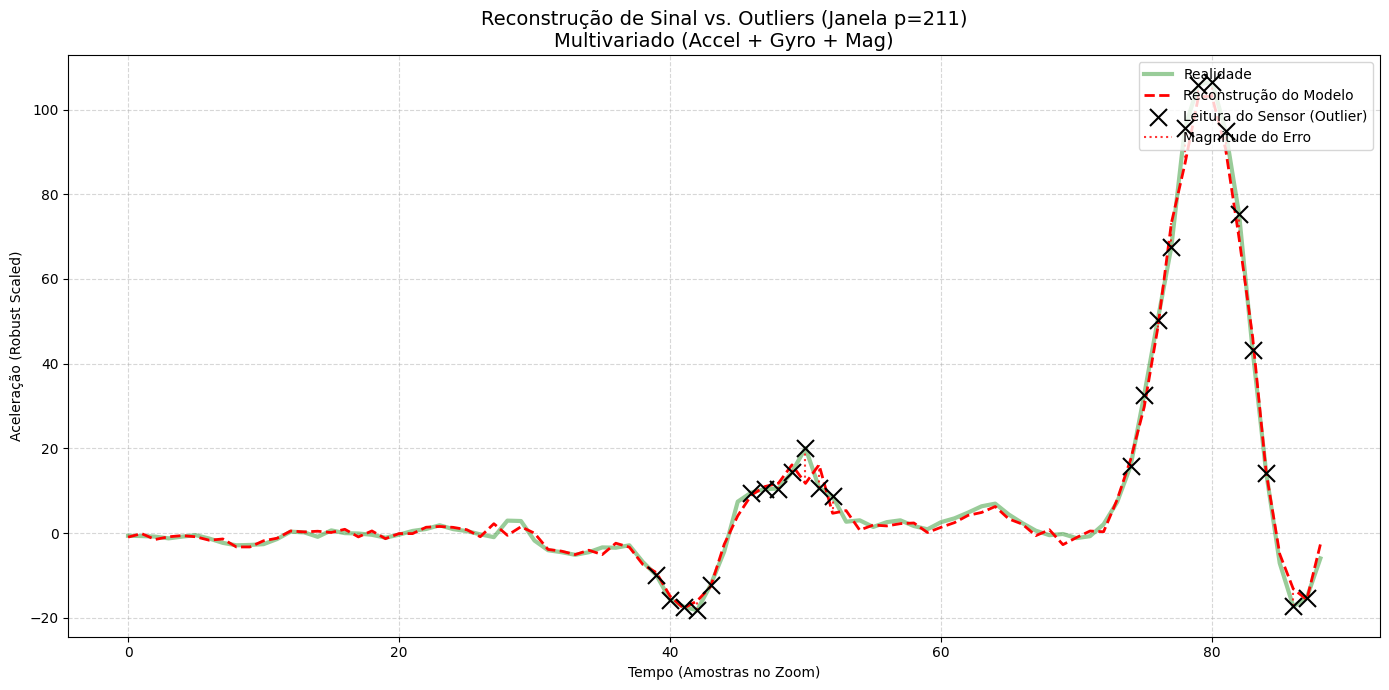


ANÁLISE DO PIOR PONTO NO ZOOM:
-> O Sensor leu:   95.6202
-> O Modelo previu:87.1253
-> Desvio detetado:8.4949 (sigma)


In [26]:
import matplotlib.pyplot as plt
import numpy as np
from utils.outliers import inject_outliers # Assumindo que esta função existe

# ==========================================
# 1. PREPARAÇÃO DOS DADOS (INJEÇÃO DE ERRO)
# ==========================================
# test_df já está escalado do passo anterior.
# Vamos extrair a coluna alvo para injetar ruído.
target_clean = test_df[TARGET_COL].to_numpy()

# Injetar Outliers (simulando falha no sensor)
# Nota: reshape(1, -1) porque a sua função inject_outliers parece esperar 2D
mask_2d, raw_noisy_2d = inject_outliers(target_clean.reshape(1, -1), x=10, k=3, z=0.5)

mask_outliers = mask_2d.flatten()
raw_noisy = raw_noisy_2d.flatten()

# Criar um DataFrame "Ruidoso" (Cópia do teste com a coluna alvo estragada)
test_df_noisy = test_df.copy()
test_df_noisy[TARGET_COL] = raw_noisy

# ==========================================
# 2. CRIAÇÃO DAS JANELAS (CENTRADA)
# ==========================================
# A. Cenário REAL (Limpo) - Para termos a referência (Linha Verde)
# X_clean: Contexto perfeito | y_clean_target: O valor real sem ruído
X_clean, y_clean_target = create_centered_window(
    test_df, TARGET_COL, optimal_window, feature_cols=FEATURE_COLS
)

# B. Cenário SENSOR (Ruidoso) - Para termos os pontos Pretos
# Só nos interessa o y_noisy_sensor (o valor central estragado)
_, y_noisy_sensor = create_centered_window(
    test_df_noisy, TARGET_COL, optimal_window, feature_cols=FEATURE_COLS
)


y_pred_ideal = final_model.predict(X_clean)

# ==========================================
# 4. ALINHAMENTO DA MÁSCARA
# ==========================================
# A função de janela remove 'half' pontos do início e do fim.
# Temos de cortar a máscara para ter o mesmo tamanho de y_pred_ideal.
half = optimal_window // 2
mask_aligned = mask_outliers[half : len(mask_outliers) - half]

# ==========================================
# 5. VISUALIZAÇÃO (ZOOM NO ERRO)
# ==========================================
indices_erros = np.where(mask_aligned)[0]

if len(indices_erros) > 0:
    # Escolher o erro mais grave para centrar o zoom
    diferencas = np.abs(y_noisy_sensor[indices_erros] - y_clean_target[indices_erros])
    idx_centro = indices_erros[np.argmax(diferencas)]
    
    # Definição do Zoom (Raio de visualização)
    raio = 50 
    inicio = max(0, idx_centro - raio)
    fim = min(len(y_pred_ideal), idx_centro + raio)
    
    # Recortes para o gráfico
    slice_clean = y_clean_target[inicio:fim]      # Verde (Verdade)
    slice_noisy = y_noisy_sensor[inicio:fim]      # Preto (Sensor Estragado)
    slice_pred  = y_pred_ideal[inicio:fim]        # Vermelho (Estimativa do Modelo)
    slice_mask  = mask_aligned[inicio:fim]        # Onde estão os erros neste pedaço?
    
    eixo_x = np.arange(len(slice_clean))
    indices_locais = np.where(slice_mask)[0]
    
    # --- PLOT ---
    plt.figure(figsize=(14, 7))
    
    # 1. Verdade (Verde)
    plt.plot(eixo_x, slice_clean, color='green', label='Realidade', linewidth=3, alpha=0.4)
    
    # 2. Previsão (Vermelho)
    plt.plot(eixo_x, slice_pred, color='red', label='Reconstrução do Modelo', linewidth=2, linestyle='--')
    
    # 3. Sensor com Defeito (X Preto)
    if len(indices_locais) > 0:
        plt.scatter(eixo_x[indices_locais], slice_noisy[indices_locais], 
                    color='black', marker='x', s=150, zorder=10, label='Leitura do Sensor (Outlier)')
        
        # Linhas Verticais de Erro (Resíduos)
        plt.vlines(eixo_x[indices_locais], slice_noisy[indices_locais], slice_pred[indices_locais], 
                   colors='red', linestyles=':', alpha=0.8, label='Magnitude do Erro')

    plt.title(f"Reconstrução de Sinal vs. Outliers (Janela p={optimal_window})\nMultivariado (Accel + Gyro + Mag)", fontsize=14)
    plt.xlabel("Tempo (Amostras no Zoom)")
    plt.ylabel("Aceleração (Robust Scaled)")
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # --- Print Numérico ---
    if len(indices_locais) > 0:
        pior_idx = indices_locais[np.argmax(np.abs(slice_noisy[indices_locais] - slice_pred[indices_locais]))]
        
        val_sensor = slice_noisy[pior_idx]
        val_modelo = slice_pred[pior_idx]
        erro_abs = abs(val_sensor - val_modelo)
        
        print(f"\nANÁLISE DO PIOR PONTO NO ZOOM:")
        print(f"-> O Sensor leu:   {val_sensor:.4f}")
        print(f"-> O Modelo previu:{val_modelo:.4f}")
        print(f"-> Desvio detetado:{erro_abs:.4f} (sigma)")
else:
    print("Nenhum outlier foi gerado ou detetado na janela alinhada.")



--- HISTOGRAMA LIMPO (Matplotlib) ---


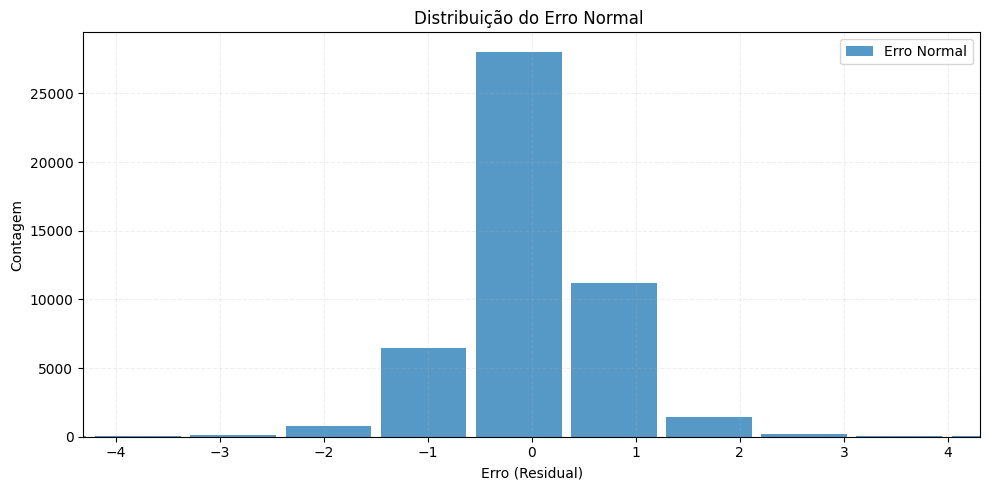

Visualização focada no intervalo: [-4.31, 4.31]


In [27]:
import matplotlib.pyplot as plt
import numpy as np

print("--- HISTOGRAMA LIMPO (Matplotlib) ---")

# 1. CALCULAR OS RESÍDUOS
residuals = y_clean_target - y_pred_ideal

# Calcular estatísticas apenas para definir o zoom
media = np.mean(residuals)
std = np.std(residuals)

# 2. PLOT
plt.figure(figsize=(10, 5))

# Histograma
# bins=100: Garante boa resolução
# rwidth=0.9: Dá um pequeno espaço entre as barras para leitura fácil
plt.hist(residuals, bins=100, color='#1f77b4', alpha=0.75, rwidth=0.9, label='Erro Normal')

# 3. DIMINUIR O EIXO X (ZOOM NA DISTRIBUIÇÃO)
# Focamos em +/- 4 vezes o desvio padrão. 
# Isto corta o espaço vazio nas pontas.
limite_zoom = 4 * std
plt.xlim(media - limite_zoom, media + limite_zoom)

# Decoração Simples
plt.title("Distribuição do Erro Normal ")
plt.xlabel("Erro (Residual)")
plt.ylabel("Contagem")
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Visualização focada no intervalo: [{media - limite_zoom:.2f}, {media + limite_zoom:.2f}]")